# FaceForensics Detection Using Spectral Analysis

This notebook is heavily based on the work presented [here](https://github.com/cc-hpc-itwm/DeepFakeDetection). Please visit
the original work for further information.

Note that this is similar to what the authors included in their original repo. For our framework, we changed the implementation
to make it as efficient and clean as possible.

This notebook has the purpose of understanding the feature creation pipeline and it might not necessary lead to
high accuracies.

### 1. Create feature

First, make sure that you have a dataset with fakes and reals.


#### 1.1 Import the necessary libraries

In [58]:
import cv2
import numpy as np
import libs.commons as com
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

#### 1.2. Set up the parameters for the spectral decomposition
The parameters are:
- data: dictionary that saves each image data and its label, 0 for fake and 1 for true
- epsilon: small value added such that we won't have to compute log(0), which is not defined (see later Section x.)
- N: final number of features used for classification
- y: list for storing labels
- error: list for storing error
- number iter: number of images used

In [59]:
epsilon = 1e-8
N = 300
mean = []
error = []

number_iter = 1000 # this is a small number of input files

Declare the following variables:
- psd1D_total: Here we save the N features of each one of the $number\_iter$ images after performing the spectral decomposition
- label_total: save label for all images
- psd1D_org_mean: result of computing the mean value for each feature
- psd1D_org_std: result of computing the standard deviation for each feature

In [60]:
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)

#### 1.4. Compute the spectral decomposition for each image
**Attention!** You have to manually change the path for the

First, load images and crop them. Next, compute the features.

To compute the features:
1. Compute the 2D FT of each image.
2. Shift the zero-component to the center of the image using np.fftshit().
3. Add epsilon to avoid log(0) later. This step is necessary for avoiding numerical issues in step 4.
4. Compute magnitude spectrum:
For this, use the formula for expressing magnitude in decibels. For reference check for example the [Matlab documentation](https://www.amazon.com/Useless-Magic-Lyrics-Florence-Welch/dp/0525577157/ref=tmm_hrd_swatch_0?_encoding=UTF8&qid=&sr=).
5. Compute the Azimuthal Mean.
6. Finally, use the computed averages and interpolate to get the N features


**Don't forget that for now data paths are set manually**

In [61]:
# counter for number of processed images
cont = 0

# fake data
rootdir = '/home/cosmin/Desktop/XRay-dataset/train/fake'

for filename in glob.glob(rootdir+"/*"):
    img = cv2.imread(filename,0)

    h = int(img.shape[0]/3)
    w = int(img.shape[1]/3)
    img = img[h:-h,w:-w]

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    psd1D = com.azimuthal_average(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]


    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 0
    if cont % 50 == 0:
        print("Processed {}/{} images".format(cont, number_iter))

    cont+=1

    if cont == number_iter:
        print("Processed {}/{} images".format(cont, number_iter))
        print("Finished processing")
        break

Processed 0/1000 images
Processed 50/1000 images
Processed 100/1000 images
Processed 150/1000 images
Processed 200/1000 images
Processed 250/1000 images
Processed 300/1000 images
Processed 350/1000 images
Processed 400/1000 images
Processed 450/1000 images
Processed 500/1000 images
Processed 550/1000 images
Processed 600/1000 images
Processed 650/1000 images
Processed 700/1000 images
Processed 750/1000 images
Processed 800/1000 images
Processed 850/1000 images
Processed 900/1000 images
Processed 950/1000 images
Processed 1000/1000 images
Finished processing


Now we can compute the mean and std for each feature using the values from each image

In [62]:
for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

Moving on to processing the real data.

**Attention:** you have to manually set the path to celebA

In [63]:
## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0
rootdir2 = '/home/cosmin/Desktop/XRay-dataset/train/real'

for filename in glob.glob(rootdir2+"/*"):
    img = cv2.imread(filename,0)

    # we crop the center
    h = int(img.shape[0]/3)
    w = int(img.shape[1]/3)
    img = img[h:-h,w:-w]

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    ret_value = com.azimuthal_average(magnitude_spectrum)
    mid = ret_value.size // 2
    psd1D = ret_value[mid:]

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 1
    if cont % 50 ==0:
        print("Processed {}/{} images".format(cont, number_iter))
    cont+=1
    
    if cont == number_iter:
        print("Finished processing")
        break

Processed 0/1000 images
Processed 50/1000 images
Processed 100/1000 images
Processed 150/1000 images
Processed 200/1000 images
Processed 250/1000 images
Processed 300/1000 images
Processed 350/1000 images
Processed 400/1000 images
Processed 450/1000 images
Processed 500/1000 images
Processed 550/1000 images
Processed 600/1000 images
Processed 650/1000 images
Processed 700/1000 images
Processed 750/1000 images
Processed 800/1000 images
Processed 850/1000 images
Processed 900/1000 images
Processed 950/1000 images
Finished processing


Compute mean and standard deviation:

In [64]:
for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])

Save the computed values in a pickle object

In [65]:
mean.append(psd1D_org_mean)
mean.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

X = psd1D_total_final
y = label_total_final

We look at the label distribution, to be sure that we have a balanced dataset.

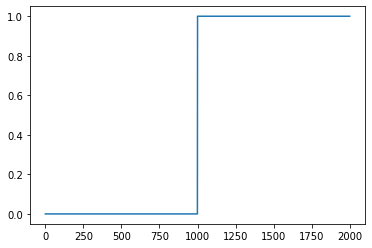

In [66]:
plt.plot(y)
plt.show()

### 3. Check Spectrum

We have a look to the spectrum. First, we initialize our variables:

In [67]:
# TODO: I think we can make this more pythonesque
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0 = 0
cont_1 = 0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

Next, we compute the statistics

In [68]:
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

Finally, we can plot the mean value and std of the frequency components

Text(0, 0.5, 'Power Spectrum')

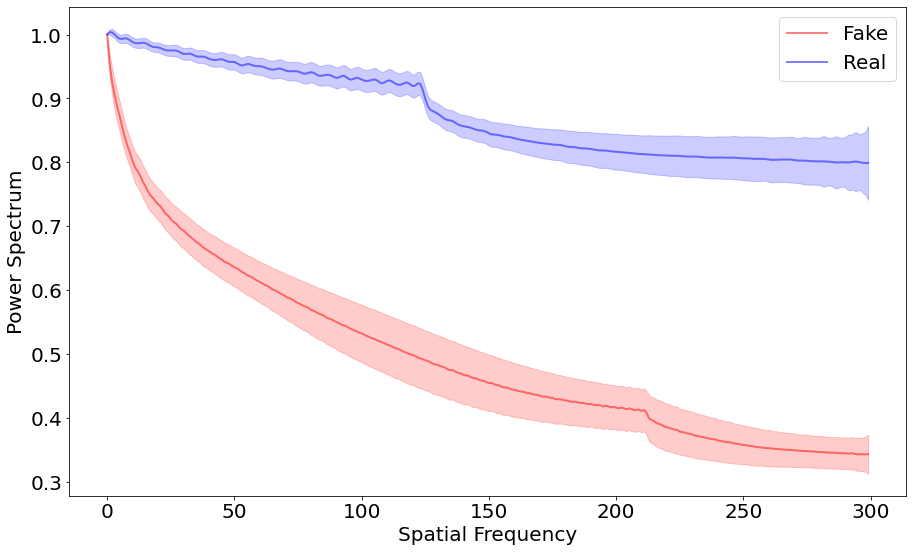

In [69]:
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
#plt.savefig('1000_celeba.png', bbox_inches='tight')

### 4. Classification

Now we classify using the features.

Set the next flag to true if you want to test with their dataset:

In [70]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

SVM_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
SVM_r.fit(X, y)

# test
# Please select a pickle files for testing
pkl_file = open('./data/features/xray_test.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_ = data["data"]
y_ = data["label"]

SVM = SVM_r.score(X_, y_)

Results using the testset:

In [71]:
print("SVM: "+str(SVM))



SVM: 0.5
